### Grid search for hyperparameters in the neural network
1. Load and process data according to modelling pipeline
2. Define functions for betting evaluation, cross-validation & grid search
3. Perform grid search
4. Investigate results to determine optimal hyperparameters. 


In [1]:
import pandas as pd 
import numpy as np
import os 
import sys 
import matplotlib.pyplot as plt
import seaborn as sns
path = r'C:\Users\rbjoe\Dropbox\Kugejl\10.semester\Topics in Social Data Science\ExamProject\data'

np.random.seed(33)

from datetime import datetime 
time_start = datetime.now()

###############################################################################
### LOAD DATA
data_train = pd.read_csv(path + '\data_train.csv', index_col=0)
data_train = data_train[data_train['league']=='England Premier League']
y = data_train['draw']
odds_prob = data_train['odds_prob_draw']
x = data_train[['ELO_home', 'ELO_away', 'home_agg_overall', 'home_def_overall',
                'away_agg_overall', 'away_def_overall', 'RR']]


###############################################################################
### IMPUTATION 
#Check for missing values 
print('Rows with any missing values:', round(x.isnull().any(axis=1).sum()/len(x),2))
print('Missing values:\n', x.isnull().sum(), sep='')

## Performance metrics are missing because of burn-in.
## Fillout burnin based on later average. 
x = x.join(data_train[['team_home', 'team_awat']])
#x['home_agg_overall'] = x.groupby('team_home').transform(lambda a: a.fillna(a.mean()))
x.loc[x['home_agg_overall'].isnull(), 'home_agg_overall'] = x.groupby('team_home')['home_agg_overall'].transform('mean')
x.loc[x['home_def_overall'].isnull(), 'home_def_overall'] = x.groupby('team_home')['home_def_overall'].transform('mean')
x.loc[x['away_agg_overall'].isnull(), 'away_agg_overall'] = x.groupby('team_awat')['away_agg_overall'].transform('mean')
x.loc[x['away_def_overall'].isnull(), 'away_def_overall'] = x.groupby('team_awat')['away_def_overall'].transform('mean')
x.drop(['team_home', 'team_awat'], axis=1, inplace=True)

#from sklearn.preprocessing import Imputer
#x = Imputer(strategy='mean').fit_transform()
x = x.fillna(x.mean())


print('Rows with any missing values:', round(x.isnull().any(axis=1).sum()/len(x),2))
#print('Missing values:\n', x.isnull().sum(), sep='')

###############################################################################
### STANDARDIZE
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(x.iloc[:,:7])
x.iloc[:,:7] = scaler.transform(x.iloc[:,:7])

Rows with any missing values: 0.2
Missing values:
ELO_home            159
ELO_away            154
home_agg_overall    122
home_def_overall    122
away_agg_overall    122
away_def_overall    122
RR                    0
dtype: int64
Rows with any missing values: 0.0


In [5]:
###############################################################################
### DEFINE A FEW FUNCTIONS

from sklearn.neural_network import MLPClassifier
from itertools import product
import multiprocessing as mp
from functools import partial
from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid

def bet_income(y, prob, odds_prob, bet=1, threshold=0.0):
    will_bet = (prob>odds_prob+threshold) #Bet if probability high enough
    correct_bets = y[will_bet]          # Bet is correct if y==1. Select chosen bets. 
#    incorrect_bets = ~y[will_bet]       # Bet is incorrect if y!=1. Select chosen bets
    odds = 1/odds_prob[will_bet]        # Calculate odds 
    
    #Calculate income
    #income = correct_bets*(odds-1)*(bet)-incorrect_bets*bet #Elementwise
    income = correct_bets*odds*bet-will_bet*bet
    income = income.sum() #Sum over matrix 
    
    #Calculate income as multiplicator of necessary capital
    if will_bet.sum() != 0: 
        income_factor = income/will_bet.sum() #
    else: income_factor = 0
    
    return income_factor

def cross_val_bet(mlp_cv, x, y, odds_prob):
    fold = KFold(n_splits=3, shuffle=True)
    profit = []
    for train, test in fold.split(x): 
        mlp_cv.fit(x.iloc[train], y.iloc[train])
        yprob = mlp_cv.predict_proba(x.iloc[test])
    #    print(mlp_cv.score(x.iloc[test], y.iloc[test]))
        profit.append(bet_income(y.iloc[test], yprob[:,1], odds_prob.iloc[test]))
    
    return np.mean(profit)

def cross_val_par(par, x, y, odds_prob): 
    timer = datetime.now()
    mlp_cv = MLPClassifier(#hidden_layer_sizes = parameters['layers'], 
                    activation='relu', solver='adam', 
#                    alpha = parameters['reg_alpha'], 
                    learning_rate_init = 10**-3, 
                    early_stopping =False, 
                    tol = 10**-4, 
                    max_iter=500, 
                    **par)
    result = par.copy()
    result['cv_score'] = cross_val_bet(mlp_cv, x, y, odds_prob)
    yprob_train = mlp_cv.predict_proba(x)[:,1]
    result['in_sample_score'] = bet_income(y,yprob_train,odds_prob)
    result['timer'] = str(datetime.now()-timer)
    return result

def grid_search_bet_serial(grid, x, y, odds_prob): 
    cv_results = pd.DataFrame(columns=[key for key in [i for i in iter(grid)][0].keys()]
                                        +['cv_score', 'in_sample_score', 'timer'])
    for par in iter(grid): 
        result = cross_val_par(par,x,y,odds_prob)
        cv_results = cv_results.append(result, ignore_index=True)
    return cv_results

def grid_search_bet(grid, x, y, odds_prob): 
    pool = mp.Pool(processes = mp.cpu_count())
    #results = pool.starmap(cross_val_par, iter(grid))
    results = pool.map(partial(cross_val_par, **{'x':x, 'y':y, 'odds_prob':odds_prob}), iter(grid))
    cv_results = pd.DataFrame(columns=[key for key in [i for i in iter(grid)][0].keys()]
                                        +['cv_score', 'in_sample_score', 'timer'])
    for result in results: 
        cv_results = cv_results.append(result, ignore_index=True)
    return cv_results


In [7]:
###############################################################################
### GRID SEARCH

#Actual grid 
params = {'hidden_layer_sizes': [i for i in range(2,90,3)]+\
                             [i for i in product(range(1,50+1,3),range(10,50,10))], 
          'alpha': [10**-i for i in range(2,6)]
          }
# Test grid
#params = {'hidden_layer_sizes': [2,4],
#          'alpha': [10**-i for i in range(1,2)]
#          }

grid = ParameterGrid(params)

if __name__ == '__main__': 
    cv_results = grid_search_bet_serial(grid,x,y,odds_prob)
    cv_results.to_csv(os.getcwd() + '\\temp\\cv_results.csv')


In [11]:
os.getcwd()

'C:\\Users\\rbjoe\\Dropbox\\Kugejl\\10.semester\\Topics in Social Data Science\\ExamProject\\code'

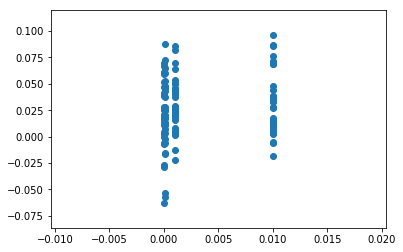

In [14]:
### Investigate grid (also used the excel file)
### 1L 
cv_results[(cv_results['hidden_layer_sizes'].str.len()!=2)].to_csv(os.getcwd() + '\\temp\\cv_results_1L.csv')
plt.scatter(cv_results[(cv_results['hidden_layer_sizes'].str.len()!=2) & (cv_results['alpha']<0.1)]['alpha'], 
         cv_results[(cv_results['hidden_layer_sizes'].str.len()!=2) & (cv_results['alpha']<0.1)]['cv_score'])
    ### Choice: 0.01


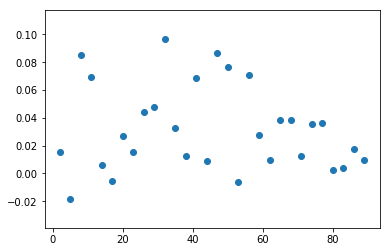

In [21]:
#    
plt.scatter(cv_results[(cv_results['hidden_layer_sizes'].str.len()!=2) & (cv_results['alpha']==0.01)]['hidden_layer_sizes'], 
         cv_results[(cv_results['hidden_layer_sizes'].str.len()!=2) & (cv_results['alpha']==0.01)]['cv_score'])
### CHoice: 32. 
#    


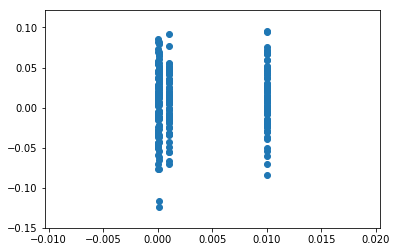

In [26]:
#    ### 2L 
cv_results[(cv_results['hidden_layer_sizes'].str.len()==2)].to_csv(os.getcwd() + '\\temp\\cv_results_2L.csv')
plt.scatter(cv_results[(cv_results['hidden_layer_sizes'].str.len()==2) & (cv_results['alpha']<0.1)]['alpha'], 
         cv_results[(cv_results['hidden_layer_sizes'].str.len()==2) & (cv_results['alpha']<0.1)]['cv_score'])
### Choice: 0.01

        

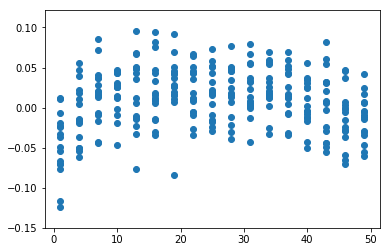

In [28]:
#    
plt.scatter([i[0] for i in cv_results[(cv_results['hidden_layer_sizes'].str.len()==2) & (cv_results['alpha']<0.1)]['hidden_layer_sizes'].str.slice(start=0)], 
         cv_results[(cv_results['hidden_layer_sizes'].str.len()==2) & (cv_results['alpha']<0.1)]['cv_score'])
### Choice: (13,40). 